In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Original

In [2]:
def score_sequence(mol):
    """Return (penalized_score, raw_survivors_in_region)."""
    
    n_x, n_y, n_z, is_lost, spin, mN = mol[:, 0], mol[:, 1], mol[:, 2], mol[:, 5], mol[:,4], mol[:,3]
    mask = (is_lost == 0) & (n_x == 0) & (n_y == 0) & (n_z == 0) & (spin == 0) & (mN == 1)
    raw = int(cp.count_nonzero(mask).get())
    return raw

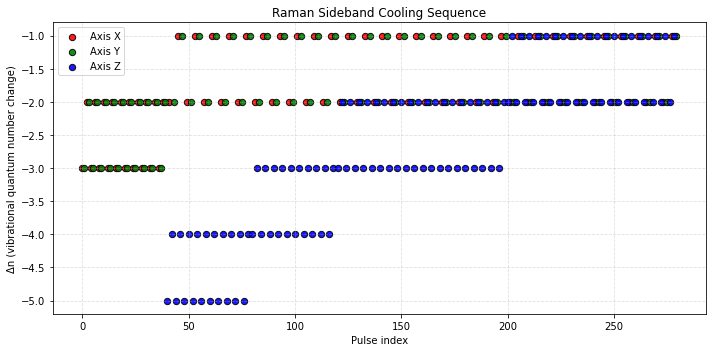

In [3]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks
seq_ori_XY = cp.tile(original_gpu[0], (10, 1))
seq_ori_XYZ1 = cp.tile(original_gpu[1], (5, 1))
seq_ori_XYZ2 = cp.tile(original_gpu[2], (5, 1))
seq_ori_XYZ3 = cp.tile(original_gpu[3], (10, 1))
seq_ori_XYZ4 = cp.tile(original_gpu[4], (10, 1))


# Repeat each block along the first axis, then concatenate in order
blocks = [
    seq_ori_XY,  
    seq_ori_XYZ1,  
    seq_ori_XYZ2,  
    seq_ori_XYZ3,  
    seq_ori_XYZ4,  
]

seq_gpu = cp.concatenate(blocks, axis=0)
cr.visualize_sequence(seq_gpu)

Raman pulses: 100%|██████████| 280/280 [00:46<00:00,  6.07it/s]


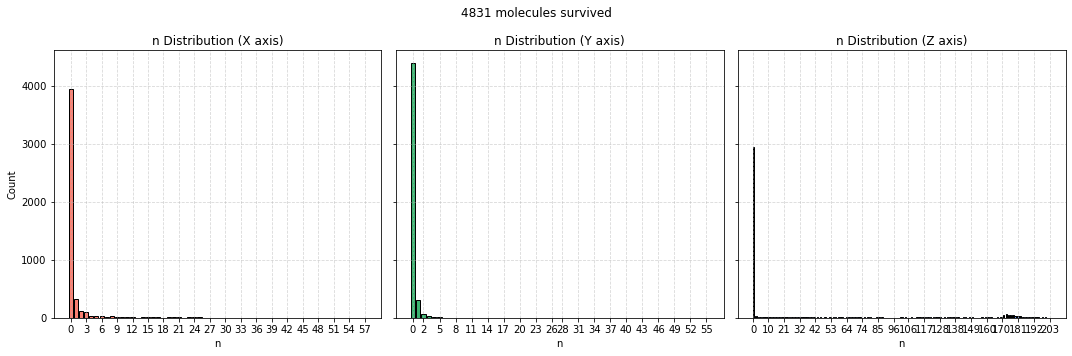

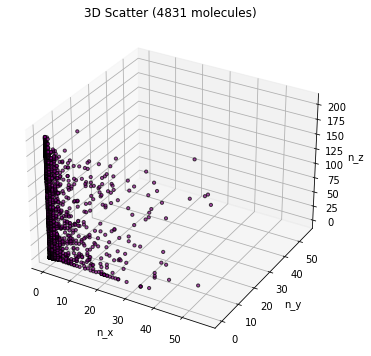

survival_rate_mean 0.4831
mot_mean [ 1.14572552  0.23411302 43.95942869]
mot_sem [0.00198431 0.00081536 0.03142711]


In [5]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_0, seq_gpu, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [6]:
score_sequence(mol_0)

2806

#### Optimized, segmental

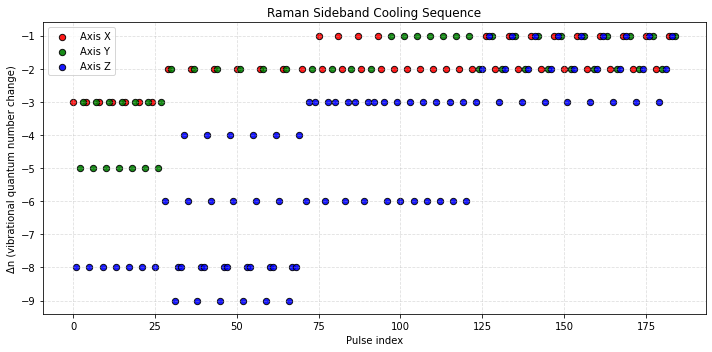

In [2]:
op_seq = np.load("ga_runs/SEGIDX_20251108_221605/final_top5/top1_sequence.npy")
cr.visualize_sequence(op_seq)

Raman pulses: 100%|██████████| 185/185 [00:33<00:00,  5.48it/s]


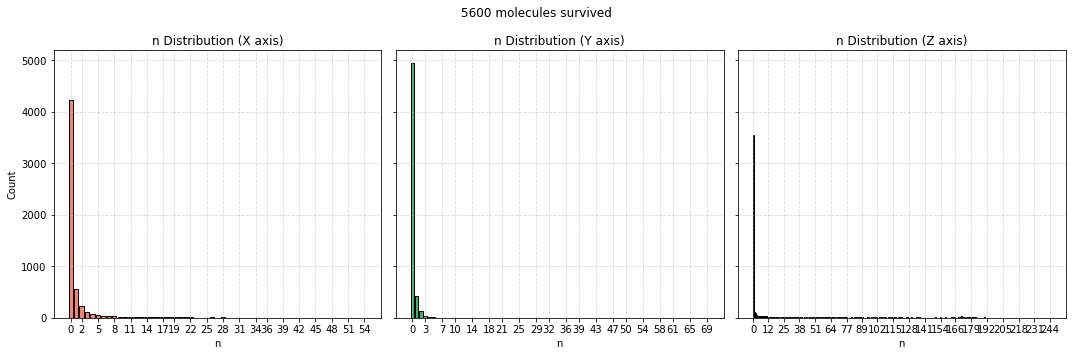

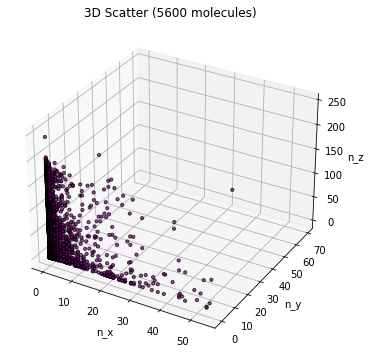

survival_rate_mean 0.56
mot_mean [ 1.34803571  0.23053571 23.625     ]
mot_sem [0.00210369 0.00067745 0.0200303 ]


In [5]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_0, op_seq, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [6]:
score_sequence(mol_0)

3190

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_n_distributions(mol_original, mol_optimized,
                         title_prefix="Motional Distribution Comparison",
                         normalize=False,
                         bar_alpha=0.6,
                         max_n=(None, None, None)):
    """
    Plot the n-distribution (x, y, z axes) for original vs optimized molecules as histograms.

    The first two (n_x, n_y) share the same y-axis.
    The third (n_z) uses its own y-axis for better scaling.
    """
    try:
        import cupy as cp
    except Exception:
        cp = None

    def to_np(arr):
        if cp is not None and isinstance(arr, cp.ndarray):
            return cp.asnumpy(arr)
        return arr
    
    mol_num = mol_original.shape[0]
    # Get distributions (may return dicts)
    ctx_orig, cty_orig, ctz_orig = cr.get_n_distribution_gpu(
        mol_original, plot=(False, False, False), scatter=False
    )
    ctx_opt, cty_opt, ctz_opt = cr.get_n_distribution_gpu(
        mol_optimized, plot=(False, False, False), scatter=False
    )

    def align_union(a, b):
        """Align dict or array distributions; return (bins, counts_a, counts_b)."""
        if isinstance(a, dict) or isinstance(b, dict):
            a = a if isinstance(a, dict) else {i: float(v) for i, v in enumerate(to_np(a))}
            b = b if isinstance(b, dict) else {i: float(v) for i, v in enumerate(to_np(b))}
            n_all = np.array(sorted(set(map(int, a.keys())) | set(map(int, b.keys()))), dtype=int)
            ca = np.array([float(a.get(int(n), 0.0)) for n in n_all], dtype=float)
            cb = np.array([float(b.get(int(n), 0.0)) for n in n_all], dtype=float)
        else:
            aa = np.asarray(to_np(a)).astype(float).ravel()
            bb = np.asarray(to_np(b)).astype(float).ravel()
            L = max(aa.size, bb.size)
            n_all = np.arange(L)
            ca = np.zeros(L, dtype=float)
            cb = np.zeros(L, dtype=float)
            ca[:aa.size] = aa
            cb[:bb.size] = bb
        if normalize:
            if ca.sum() > 0:
                ca /= mol_num
            if cb.sum() > 0:
                cb /= mol_num
        return n_all, ca, cb

    nx, cx_o, cx_n = align_union(ctx_orig, ctx_opt)
    ny, cy_o, cy_n = align_union(cty_orig, cty_opt)
    nz, cz_o, cz_n = align_union(ctz_orig, ctz_opt)

    # Compute y limits separately
    y_max_xy = max(cx_o.max(initial=0), cx_n.max(initial=0),
                   cy_o.max(initial=0), cy_n.max(initial=0))
    y_max_z = max(cz_o.max(initial=0), cz_n.max(initial=0))

    # Create figure: 3 subplots but z has its own y-scale
    fig = plt.figure(figsize=(15, 4))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1.1])  # last wider for label room
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)   # share y with x
    ax3 = fig.add_subplot(gs[0, 2])               # independent y-axis

    def plot_hist(ax, n, orig, opt, label, color, max_limit, y_max):
        
        width = 0.3

        ax.bar(n - width/2, orig, width=width, color="gray", alpha=bar_alpha, label="Original")
        ax.bar(n + width/2, opt,  width=width, color=color, alpha=bar_alpha, label="Optimized")

        ax.set_title(f"n_{label} distribution")
        ax.set_xlabel(f"n_{label}")
        ax.set_ylim(0, y_max * 1.05)

        if max_limit is None:
            ax.set_xlim(n.min() - width, n.max() + width)
        else:
            ax.set_xlim(n.min() - width, max_limit + width)
        ax.grid(True, linestyle="--", alpha=0.5)

    # Plot X, Y with shared y-axis
    plot_hist(ax1, nx, cx_o, cx_n, "x", "tab:red", max_n[0], y_max_xy)
    plot_hist(ax2, ny, cy_o, cy_n, "y", "tab:green", max_n[1], y_max_xy)
    # Plot Z with its own y-axis scaling
    plot_hist(ax3, nz, cz_o, cz_n, "z", "tab:blue", max_n[2], y_max_z)

    # Label adjustments
    ylabel = "Probability" if normalize else "Count"
    ax1.set_ylabel(ylabel)
    fig.suptitle(title_prefix, fontsize=14)

    # Combine legends
    fig.legend(loc="upper left", ncol=3, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


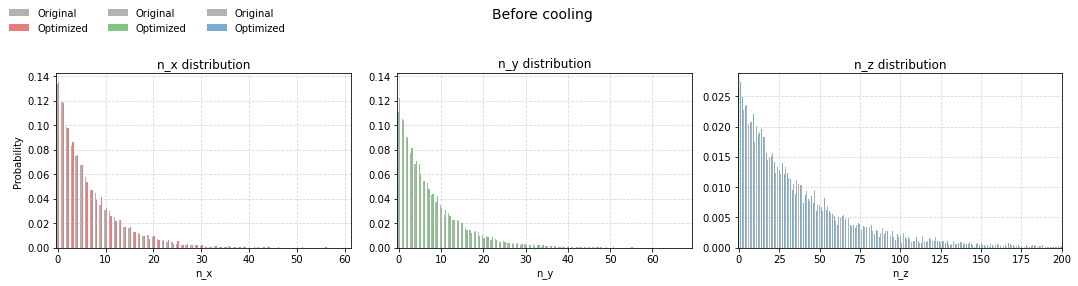

In [12]:
mol_original = cr.build_thermal_molecules_gpu(10_000, temp)
mol_optimized = cr.build_thermal_molecules_gpu(10_000, temp)

plot_n_distributions(mol_original, mol_optimized, title_prefix='Before cooling', max_n=(None, None, 200), normalize=True)

Raman pulses: 100%|██████████| 185/185 [00:33<00:00,  5.59it/s]


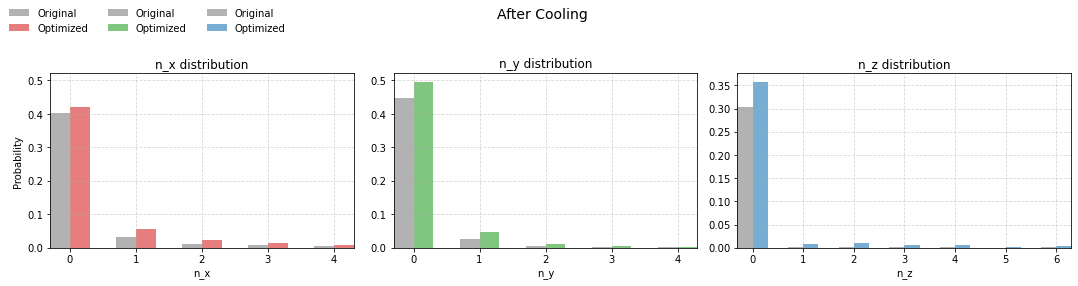

In [13]:
cr.raman_cool_with_pumping(mol_original, seq_gpu, res, show_progress=True)
cr.raman_cool_with_pumping(mol_optimized, op_seq, res, show_progress=True)

plot_n_distributions(mol_original, mol_optimized, title_prefix='After Cooling', max_n=(4, 4, 6), normalize=True)

In [5]:
import json
with open("ga_runs/SEGIDX_20251108_221605/final_top5/top1_meta.json") as file:
    op_seq_meta = json.load(file)

In [18]:
def segments_to_cooling_sequence(meta: dict, include_op: bool = True):
    """
    Convert a segmented GA result (with 'segments' -> list of {'rep', 'pairs'}) into:
      cooling_sequence = [(rep, "X3,OP,Y2,OP,..."), ...]

    - 'pairs' are [axis, delta_n] with axis 0:X, 1:Y, 2:Z
    - delta_n appears as its absolute value in the label (e.g., -3 -> '3')
    - include_op=True inserts 'OP' after every pulse (matches your example)
    """
    axis_letter = {0: "X", 1: "Y", 2: "Z"}
    out = []
    for seg in meta.get("segments", []):
        rep = int(seg["rep"])
        parts = []
        for ax, dn in seg["pairs"]:
            parts.append(f"{axis_letter[int(ax)]}{abs(int(dn))}")
            if include_op:
                parts.append("OP")
        s = ",".join(parts)
        out.append((rep, s))
    return out


In [19]:
out = segments_to_cooling_sequence(op_seq_meta)

In [20]:
out

[(7, 'X3,OP,Z8,OP,Y5,OP,Y3,OP'),
 (6, 'Z6,OP,X2,OP,Y2,OP,Z9,OP,Z8,OP,Z8,OP,Z4,OP'),
 (4, 'X2,OP,Z6,OP,Z3,OP,Y2,OP,Z3,OP,X1,OP'),
 (7, 'X2,OP,Z3,OP,Z6,OP,Y1,OP'),
 (9, 'X2,OP,Z3,OP,Y2,OP,Z2,OP,X1,OP,Z1,OP,Y1,OP')]

### Check distribution after each segment

In [9]:
import numpy as np
import cupy as cp
from cu_rsc.build_sequence import pulse_time  # uses your existing function

def meta_to_pulse_segments(meta: dict, *, to_gpu: bool = True):
    """
    Convert segmented GA meta into a list of (N,3) pulse matrices:
      [axis, delta_n, time] with time from pulse_time(axis, delta_n).

    - Repeats each segment 'rep' times.
    - Returns a list of 5 arrays (NumPy if to_gpu=False, CuPy if to_gpu=True).
    - Does NOT insert OP pulses; OP cycles are handled by the simulation (K_max).

    Parameters
    ----------
    meta : dict
        Must contain key "segments", each with {"rep": int, "pairs": [[axis, dN], ...]}
    to_gpu : bool
        If True, return CuPy arrays; else NumPy arrays.

    Returns
    -------
    segments_out : list of arrays
        Each element has shape (rep * len(pairs), 3) with dtype float64.
    """
    segs = meta.get("segments", [])
    if not segs:
        raise ValueError("meta['segments'] is empty or missing.")

    segments_out = []
    for seg in segs:
        rep = int(seg["rep"])
        pairs = seg["pairs"]
        if not pairs:
            # empty segment -> empty (0,3)
            base = np.zeros((0, 3), dtype=np.float64)
        else:
            # build one pass of this segment
            base_rows = []
            for ax, dn in pairs:
                t = float(pulse_time(int(ax), int(dn)))
                base_rows.append([int(ax), int(dn), t])
            base = np.asarray(base_rows, dtype=np.float64)

        # repeat 'rep' times along rows
        if rep > 1 and base.shape[0] > 0:
            base = np.tile(base, (rep, 1))

        # axis/delta_n integral in storage (kept as floats for (P,3) convention)
        base[:, 0] = np.rint(base[:, 0])
        base[:, 1] = np.rint(base[:, 1])

        segments_out.append(cp.asarray(base) if to_gpu else base)

    return segments_out


In [10]:
segments_op = meta_to_pulse_segments(op_seq_meta, to_gpu=True)

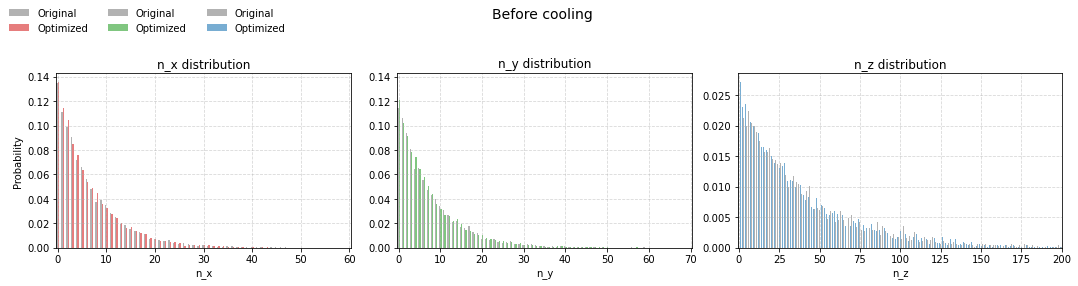

In [18]:
temp = [25e-6, 25e-6, 25e-6]
mol_original = cr.build_thermal_molecules_gpu(10_000, temp)
mol_optimized = cr.build_thermal_molecules_gpu(10_000, temp)

plot_n_distributions(mol_original, mol_optimized, title_prefix='Before cooling', max_n=(None, None, 200), normalize=True)

Raman pulses: 100%|██████████| 28/28 [00:04<00:00,  6.17it/s]


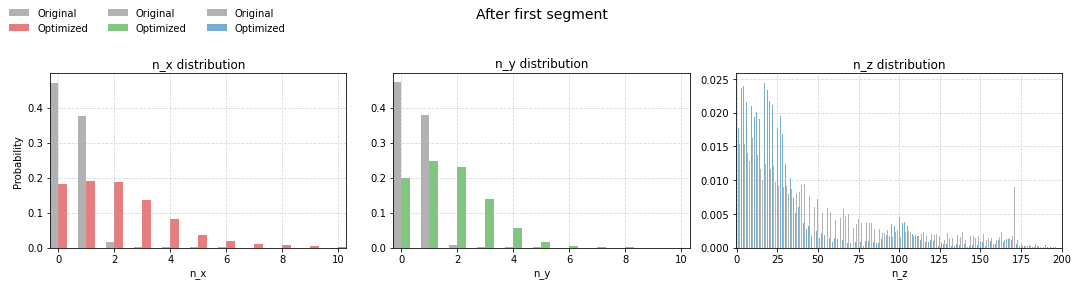

In [19]:
cr.raman_cool_with_pumping(mol_original, seq_ori_XY, res, show_progress=True)
cr.raman_cool_with_pumping(mol_optimized, segments_op[0], res, show_progress=True)

plot_n_distributions(mol_original, mol_optimized, title_prefix='After first segment', max_n=(10, 10, 200), normalize=True)

Raman pulses: 100%|██████████| 42/42 [00:07<00:00,  5.92it/s]


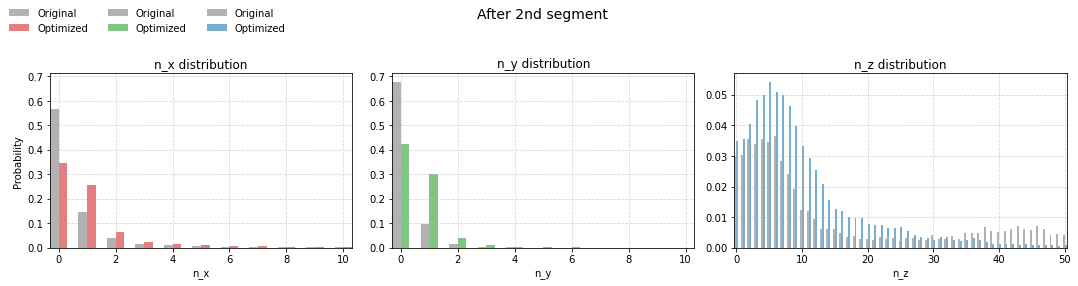

In [20]:
cr.raman_cool_with_pumping(mol_original, seq_ori_XYZ1, res, show_progress=True)
cr.raman_cool_with_pumping(mol_optimized, segments_op[1], res, show_progress=True)

plot_n_distributions(mol_original, mol_optimized, title_prefix='After 2nd segment', max_n=(10, 10, 50), normalize=True)

Raman pulses: 100%|██████████| 24/24 [00:04<00:00,  5.69it/s]


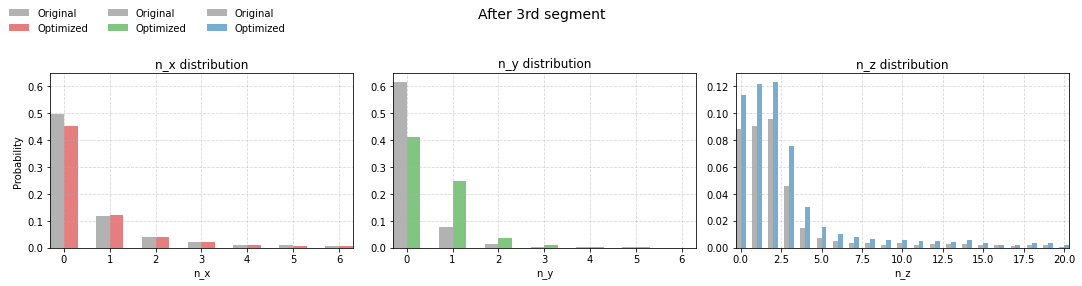

In [21]:
cr.raman_cool_with_pumping(mol_original, seq_ori_XYZ2, res, show_progress=True)
cr.raman_cool_with_pumping(mol_optimized, segments_op[2], res, show_progress=True)

plot_n_distributions(mol_original, mol_optimized, title_prefix='After 3rd segment', max_n=(6, 6, 20), normalize=True)

Raman pulses: 100%|██████████| 28/28 [00:05<00:00,  5.10it/s]


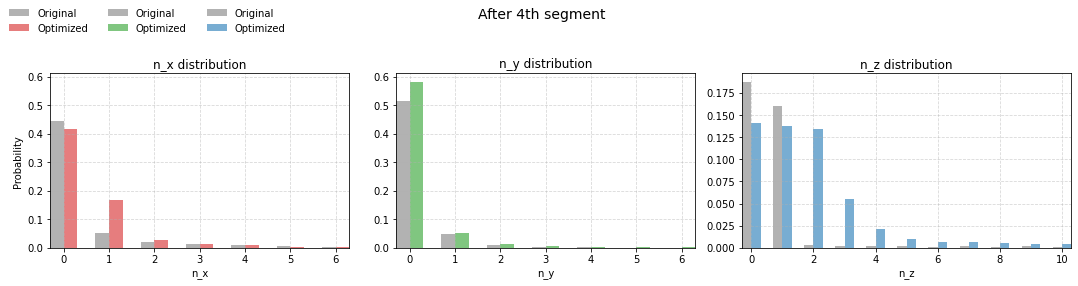

In [22]:
cr.raman_cool_with_pumping(mol_original, seq_ori_XYZ3, res, show_progress=True)
cr.raman_cool_with_pumping(mol_optimized, segments_op[3], res, show_progress=True)

plot_n_distributions(mol_original, mol_optimized, title_prefix='After 4th segment', max_n=(6, 6, 10), normalize=True)

Raman pulses: 100%|██████████| 63/63 [00:10<00:00,  5.79it/s]


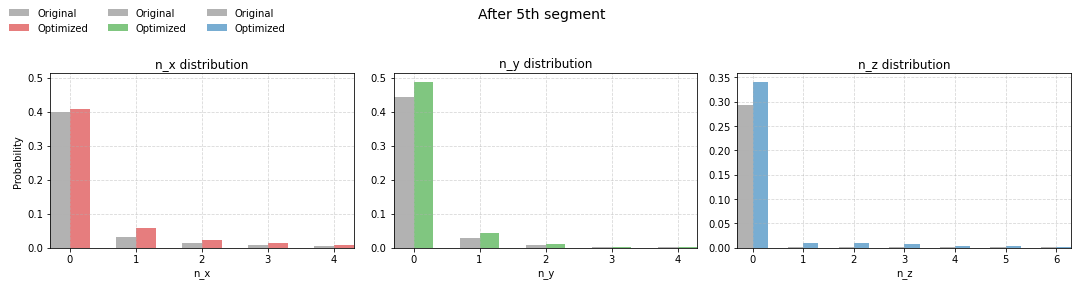

In [23]:
cr.raman_cool_with_pumping(mol_original, seq_ori_XYZ4, res, show_progress=True)
cr.raman_cool_with_pumping(mol_optimized, segments_op[4], res, show_progress=True)

plot_n_distributions(mol_original, mol_optimized, title_prefix='After 5th segment', max_n=(4, 4, 6), normalize=True)